# NS FLASH ASSIGNMENT 1

# Introduction

In [ ]:
The White Helmets is an organization that records their humanitarian aid in Syria to get sponsors from abroad. A disinformation campaign has arisen, however, which states that the White Helmets may be staging these rescue operations. Therefore, in this project, we are investigating the White Helmets dataset (pairwise_52seconds_share.csv) to see whether it contains inorganic network patterns. From the dataset we generate two relevant graphs: 1. a weighted bipartite Video-User graph which shows which users (re)posted which videos, and 2. a weighted User-User graph that links users that posted the same video within 52 seconds of each other.   
The aim of this research is to see whether the White Helmets User-User graph behaves like a known network model. We will compare the graph with three different network families: 1. the Erdos-Renyi (ER) model, 2. the Watts-Strogatz (WS) model, and 3. the Barabasi-Albert (BA) model. All network models will have an approximately similar number of nodes and density as the White Helmets User-User graph. 
We will finetune the hyperparameters used in each model (by hand) and then describe all graphs using the following five metrics: 1. node degree, 2. average clustering coefficient, 3. betweenness centrality, 4. degree centrality, and 5. average shortest path length. In the end, we hope to find patterns in the White Helmets dataset that appear to be (in)organic and to see similarities between the dataset and the different network models. Inorganic patterns we find may be investigated in future work, for example to determine the underlying social structure within the White Helmets organization. 



# Methodology

## Step 0: Installing Libaries

In [1]:
%pip install pandas networkx matplotlib seaborn numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step 1: Load & Clean White Helmets data

In [5]:
df = pd.read_csv('pairwise_52seconds_share.csv')
print(df.head())
print(df.info())

   Unnamed: 0      videoID                  userID_1  \
0           0  -6bGXfM8-gs  19372991|840224732847833   
1          10  -fJbMWhkTAw    Ej8Mm0YMadzmx4osDA_hgg   
2          11  -ilNuSh1Fgw    feNNP607aG1F64jR6bk8jw   
3          12  -ilNuSh1Fgw    5SDVRa-J-_cWYP6g0WNzLw   
4          13  -ilNuSh1Fgw    42Egn_22OjOzg2XMqAa9_g   

                   userID_2          timestamp_1          timestamp_2  \
0  19372991|840224732847833  2018-07-22 21:19:58  2018-07-22 21:19:58   
1    Ej8Mm0YMadzmx4osDA_hgg  2018-08-01 00:51:08  2018-08-01 00:51:08   
2    CVEf5dB1MvNRTQFYivAIPQ  2018-04-27 22:28:49  2018-04-27 22:29:36   
3    jz6hyweGgVHGTw-PbEMqKw  2018-05-14 16:52:08  2018-05-14 16:52:24   
4    poH0yvIGbS5_7MdXM4EuRA  2018-05-14 16:55:04  2018-05-14 16:55:15   

   time_diff_seconds  
0                0.0  
1                0.0  
2               47.0  
3               16.0  
4               11.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns

In [7]:
# Rename column with missing title in csv:
df.rename(columns={'Unnamed: 0': 'edgeID'}, inplace=True)

# Check for missing values
print("\nMissing Values per column")
print(df.isnull().sum())

# Check for duplicate rows
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# --- INVALID VALUES CHECKS ---

# 1. Time difference too large or negative
invalid_time_diff = df[(df['time_diff_seconds'] < 0.0) | (df['time_diff_seconds'] > 52.0)]
print(f"\nRows with invalid time differences: {len(invalid_time_diff)}")

# 2. Self-edges (user connected to itself)
same_user = df[df['userID_1'] == df['userID_2']]
print(f"Rows that connect edge to itself: {len(same_user)}")

# Remove self-edges
df = df[df['userID_1'] != df['userID_2']]
print(f"Remaining rows after removing self-edges: {len(df)}")

# 3. Edges with zero time difference (optional cleanup)
zero_time_diff = df[df['time_diff_seconds'] == 0.0]
print(f"Number of edges where time_diff_seconds is 0.0: {len(zero_time_diff)}")

# Show details for review
if len(zero_time_diff) > 0:
    print(zero_time_diff.head())

# Final dataframe info
print("\nDataFrame info after cleanup:")
print(df.info())



Missing Values per column
edgeID               0
videoID              0
userID_1             0
userID_2             0
timestamp_1          0
timestamp_2          0
time_diff_seconds    0
dtype: int64

Duplicate Rows: 0

Rows with invalid time differences: 0
Rows that connect edge to itself: 344
Remaining rows after removing self-edges: 4127
Number of edges where time_diff_seconds is 0.0: 14
      edgeID      videoID                   userID_1                userID_2  \
161      260  2Jb_lpdNRU8    2572694|885420584986830  3QOONeDucvajwi1U1Y5Z7A   
206      310  3tIupmpY7IA  16548407|1821040977916389  LEb7CblKLJHjHCnmytR5UQ   
482      698  9gXHcOIhB7s     r73dGcK2Gcx8t6UNE1dRHA  GioWuAM9ufsQlV_-1mkHiw   
2501    2731  CLRsB_QJvkI     PMyrVtWQnGWB0QwsKS_NGw  uv3ZAO5Gd5HoRoPdQEywLQ   
3486    3878  OCrY6Q_qZUY    318216|2356029011082368  g6dCJe_oS3-vGq9WrCu6QQ   

              timestamp_1          timestamp_2  time_diff_seconds  
161   2018-08-01 03:00:00  2018-08-01 03:00:00          

## Step 2: Getting to know our data

In [9]:
#Get the unique number of users in the dataset
find_unique_users = pd.unique(df[['userID_1', 'userID_2']].values.ravel())
unique_users = len(find_unique_users)
print(f"Unique numbers of users:", unique_users)

#Get the number of unique videos posted
unique_videos = len(df['videoID'].unique())
print(f"Unique numbers of videos:", unique_videos)


Unique numbers of users: 4030
Unique numbers of videos: 212


## Step 3: Build graphs for White Helmets data 
### Two graphs: (User <-> User, Video <-> User)

Number of Edges in User-User Graph: 4078


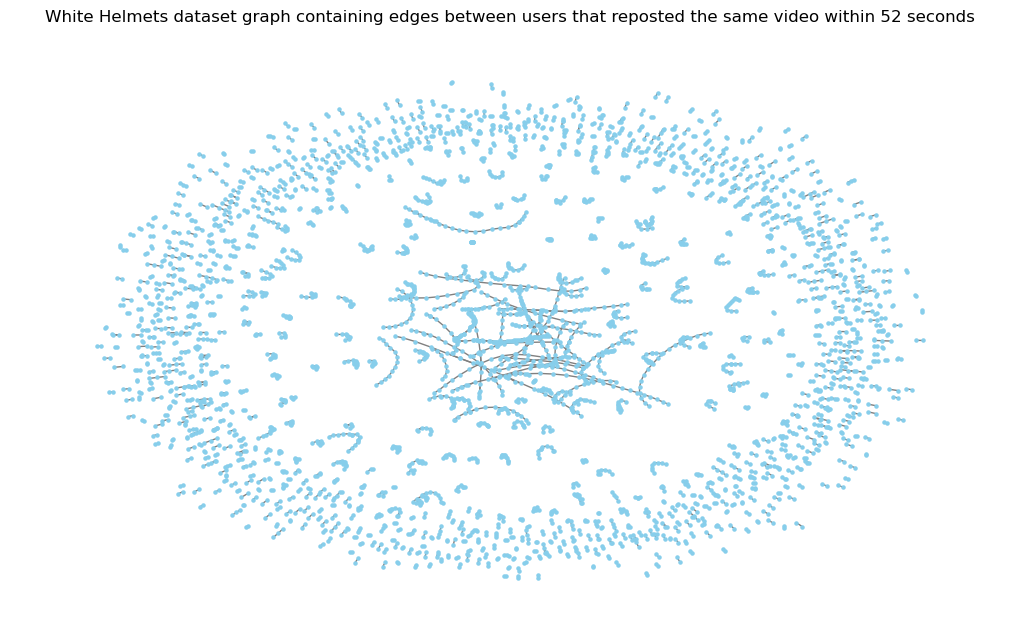

In [12]:
# Build weighted User-User Graph

edge_weights = (
    df.groupby(['userID_1', 'userID_2'])
    .size()
    .reset_index(name='weight')
)

User_graph = nx.from_pandas_edgelist( # Creating an edgelist from the dataframe
    edge_weights,
    source='userID_1', # Undirected network. Edges between users
    target='userID_2',
    edge_attr='weight',
    create_using=nx.Graph()
)

UserGraph_n_edges = User_graph.number_of_edges()
print(f"Number of Edges in User-User Graph:", UserGraph_n_edges)

plt.figure(figsize=(10, 6))
nx.draw(User_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title('White Helmets dataset graph containing edges between users that reposted the same video within 52 seconds')
plt.show()

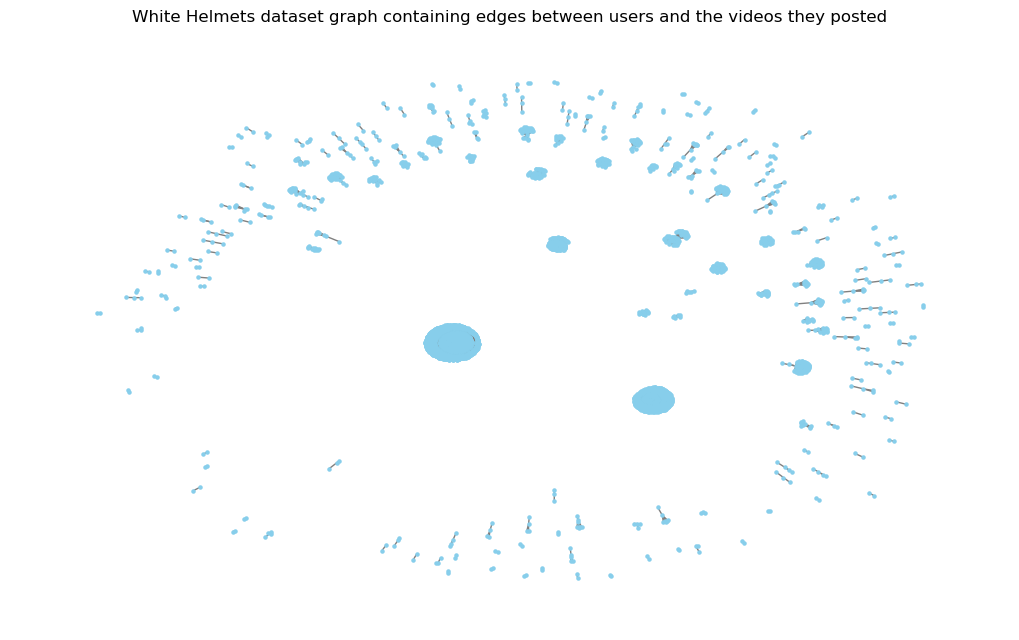

In [14]:
# Build VideoID-User1 Graph
edge_weights = df.groupby(['videoID', 'userID_1']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User1_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_1',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User1_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title('White Helmets dataset graph containing edges between users and the videos they posted')
plt.show()


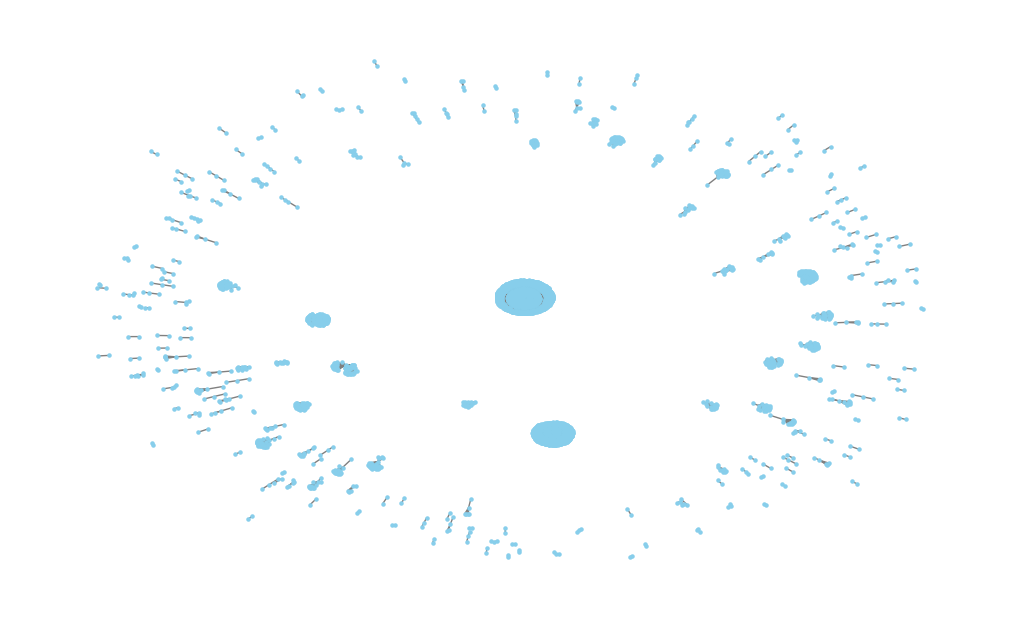

In [16]:
# Build VideoID-User2 Graph
edge_weights = df.groupby(['videoID', 'userID_2']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User2_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_2',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User2_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()


Number of Edges in Video-User Graph: 4091


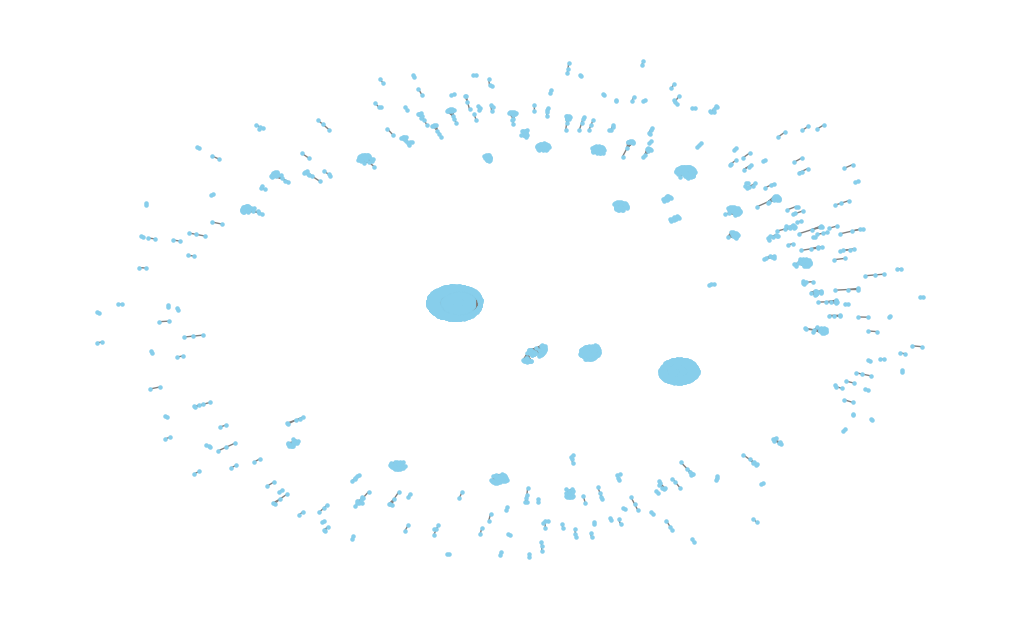

Number of Unique Users: 4030
Number of Unique Videos: 212


In [19]:
# Merge graphs above to get User <-> Video graph:

# Melt the two user columns into one
user_video_pairs = pd.melt(
    df,
    id_vars=['videoID'],
    value_vars=['userID_1', 'userID_2'], #melt these two together
    var_name='user_type', #shows from which column the user came --> maybe we can remove this column as it might just add confusion
    value_name='userID' #name of the melted column
)

# Aggregate weights: shows the #interactions per user-video pair
edge_weights = user_video_pairs.groupby(['videoID', 'userID']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
video_user_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID',
    edge_attr='weight',
    create_using=nx.Graph()
)

UserVideoGraph_n_edges = video_user_graph.number_of_edges()
print(f"Number of Edges in Video-User Graph:", UserVideoGraph_n_edges)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User2_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()

# Check loss of instances (videos or users) --> outputs below give the same number so no loss of instances.
# Get the unique number of users in the dataset
find_unique_users_in_graph = pd.unique(user_video_pairs['userID'])
unique_users_in_UVgraph = len(find_unique_users_in_graph)
print(f"Number of Unique Users:", unique_users_in_UVgraph)

# Get the number of unique videos posted
unique_videos = len(user_video_pairs['videoID'].unique())
print(f"Number of Unique Videos:", unique_videos)

In [75]:
from networkx.algorithms import bipartite 

# Create the bipartite graph
video_user_graph = nx.Graph()
video_user_graph.add_nodes_from(edge_weights['videoID'].unique(), bipartite=0)  # videos
video_user_graph.add_nodes_from(edge_weights['userID'].unique(), bipartite=1)  # users

# Add weighted edges
for _, row in edge_weights.iterrows():
    video_user_graph.add_edge(row['userID'], row['videoID'], weight=row['weight'])

is_bipartite = bipartite.is_bipartite(video_user_graph)
print(f"Is bipartite: {is_bipartite}")

# Get the node sets (helps position the two groups separately)
video_nodes = set(n for n, d in VideoID_User1_graph.nodes(data=True) if d['bipartite'] == 0)
user_nodes = set(video_user_graph) - video_nodes

# Define positions: one group left, one right
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(video_nodes))
pos.update((n, (2, i)) for i, n in enumerate(user_nodes))

plt.figure(figsize=(10, 6))
nx.draw(video_user_graph, pos=pos, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title("Bipartite visualization of Video-User")
plt.show()


Is bipartite: True


KeyError: 'bipartite'

## Step 4: Get Relevant Network Metrics

#### 1. Density

In [21]:
#density_User1 = nx.density(VideoID_User1_graph)
#density_User2 = nx.density(VideoID_User2_graph)
density_UserGraph = nx.density(User_graph)
density_UserVideoGraph = nx.density(video_user_graph)

print("Density:")
#print(f"VideoID–User1 Graph: {density_User1:.4f}")
#print(f"VideoID–User2 Graph: {density_User2:.4f}")
print(f"VideoID–UserID Graph: {density_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {density_UserGraph:.4f}")


Density:
VideoID–UserID Graph: 0.0005
User1–User2 Graph:  0.0005


Justification of metric:
The density measure is normalized between 0 and 1, which allows for easy comparison between different networks. It gives an indicator of how sparse or dense a network is. If the density values of networks differ drastically, the rate of interaction in these networks will probably be very different. In our study, the density metric is not a measure that we will directly compare between the White Helmets dataset and different network models. Rather, we will match the density of our random networks with the density of the White Helmets dataset (0.0005) to ensure that not only the number of nodes but also the number of edges in the networks are similar. This should create a similar amount of interaction between nodes, which - using the other metrics below - allows us to investigate whether the White Helmets dataset is in accordance with the Watts-Strogatz or Barabasi-Albert model (or neither).

### 2. Node degree

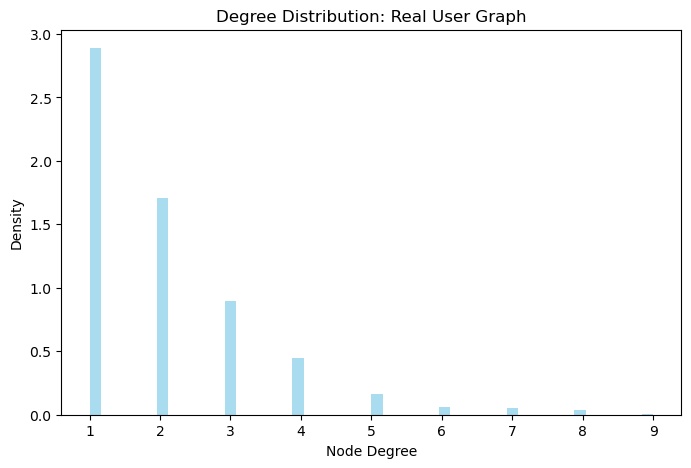

In [23]:
#SHOW THE DISTRIBUTION

#FIND KEY PLAYERS WHOSE DEGREE > E.G. 10

'''
def find_key_players(pair): 
    ID, normalized_repost_value = pair
    if normalized_repost_value >= 0.1:
        return True  # keep pair in the dictionary
    else:
        return False  # filter pair out of the filtered dictionary
    
#deg_cent_User1 = nx.degree_centrality(VideoID_User1_graph)
#deg_cent_User2 = nx.degree_centrality(VideoID_User2_graph)
deg_cent_UserGraph = nx.degree_centrality(User_graph)
deg_cent_UserVideoGraph = nx.degree_centrality(video_user_graph)

key_players_UserGraph = dict(filter(find_key_players, deg_cent_UserGraph.items()))
key_players_UserVideoGraph = dict(filter(find_key_players, deg_cent_UserVideoGraph.items()))

print("Degree centrality (videoID: value):")
print(f"User1–User2 Graph:  {key_players_UserGraph}")
print(f"UserID–VideoID Graph:  {key_players_UserVideoGraph}")
'''

# Degree Distribution
plt.figure(figsize=(8,5))
plt.hist([d for _, d in User_graph.degree()], bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution: Real User Graph')
plt.show()


#ALSO CALC AVERAGE DEGREE?


Justification of metric: 
Node degree is a measure that allows us to understand the flow of a graph. By looking at the degree distribution we can identify the presence of any hubs or 'key players' in the networks and see whether the graphs follow an organic, scale-free pattern or not. It helps to avoid under- or overestimating the rate of interactions in the network.

For the different network families we expect a different nide degree distribution:
- For ER, we expect a Poisson distribution
- For WS, we expect a similar average degree but with local clusters
- For BA, we expect to see a few high-degree hubs

By filtering out the key players who have the highest node degree, we can look for these players in the graphs to see if they exhibit inorganic behaviors/conspire together.

### 3. Average Clustering Coefficient

In [46]:
avg_clustering_UserVideoGraph = nx.average_clustering(video_user_graph)
avg_clustering_UserGraph = nx.average_clustering(User_graph)

print("Average clustering coefficient:")
print(f"VideoID–UserID Graph: {avg_clustering_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {avg_clustering_UserGraph:.4f}")

Average clustering coefficient:
VideoID–UserID Graph: 0.0000
User1–User2 Graph:  0.2998


Justification of metric: the clustering coefficient (CC) measures the degree to which nodes in a network tend to cluster together on a normalized scale of [0,1]. It can be used in social networks - together with graph visualization - to determine whether there exist social (sub)groups in a given network. This metric is only relevant for the User-User graph as the Video-User graph is a bipartite graph, which has a CC of 0. If we see a CC > 0 for the User-User graph, this suggests it is worth looking into these clusters to discover any distinct network patterns (e.g. agenda broadcasting). Clustering indicates an organic structure as we see this in many non-random networks.

- For ER, we expect low clustering as this models a random network
- For WS, we expect to see high clustering
- For BA, we expect moderate clustering 

### 4. Betweenness Centrality

In [48]:
#Outputs a dictionary with the betweenness centrality values for the nodes
bet_cent_UserVideoGraph = nx.betweenness_centrality(video_user_graph)
bet_cent_UserGraph = nx.betweenness_centrality(User_graph)

#SHOW DISTRIBUTION
#ALSO CALC MAX BETWEENNESS CENTRALITY?

print("Betweenness centrality:")
#print(f"VideoID–User1 Graph: {avg_betweenness_User1:.7f}")
#print(f"VideoID–User2 Graph: {avg_betweenness_User2:.7f}")
print(f"VideoID–UserID Graph: {avg_betweenness_UserVideoGraph:.7f}")
print(f"User1–User2 Graph:  {avg_betweenness_UserGraph:.7f}")

# Betweenness Centrality Distribution
plt.figure(figsize=(8,5))
plt.hist(list(bet_cent_UserGraph.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality Distribution: Real User Graph')
plt.show()

Betweenness centrality:


NameError: name 'avg_betweenness_UserVideoGraph' is not defined

Justification of metric: 
The betweenness centrality shows the importance of individual nodes in the network. It gives an idea of how centralized a network is and allows us to understand if there are indivudal nodes that control the information flow (in our case: video reposts). In organic networks, some nodes will have a more powerful position and control this information flow.

- For BA networks we expect bridging hubs that show high betweenness
- For ER and WS networks, we expect a more evenly distributed degree centrality

### 5. Degree Centrality

In [173]:
#SHOW DISTRIBUTION

deg_centrality_real = nx.degree_centrality(User_graph)

# Degree Centrality Distribution
plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality Distribution: Real User Graph')
plt.show()

#ALSO CALC MAX DEGREE CENTRALITY

Degree centrality (videoID: value):
User1–User2 Graph:  {}
UserID–VideoID Graph:  {'CCmN6X_7kn0': 0.4058005187455789, 'DPgOnD0n9uw': 0.1325159160575336}


Justification of metric: Degree centrality measures a node's importance based on the amount of connections (edges) it has. It thus highlights any potential "influencers" that may orchestrate the reposting of the White Helmets videos. As we have a weighted network, the degree centrality will differ from the node degree.

- For ER networks, degree centrality should follow a roughly uniform pattern
- For WS, there are no influencers meaning all nodes have a similar degree centrality
- For BA networks, we expect a few nodes to dominate due to the preferential attachment property

### 6. Average Shortest Path Length

In [51]:
def avg_shortest_path(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        largest_component = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_component)
        return nx.average_shortest_path_length(subgraph)

avg_path_UserVideoGraph = avg_shortest_path(video_user_graph)
avg_path_UserGraph = avg_shortest_path(User_graph)

print("Average shortest path length (of the largest connected component):")
print(f"UserID–VideoID Graph:  {avg_path_UserVideoGraph:.4f}")
print(f"User1–User2 Graph:  {avg_path_UserGraph:.4f}")

Average shortest path length (of the largest connected component):
UserID–VideoID Graph:  1.9988
User1–User2 Graph:  8.9026


Justification of metric:
The average shortest path length is good way to see how fast information can spread through a network. Especially in the case of the White Helmets dataset it is crucial to see how fast users can spread videos and therefore information to reach their goal. A shorter average shortest path indicates that very quickly and makes the network possibly very important. The reason we chose this metric rather than the diameter metric is because the average shortest path is more robust to outliers. Note that we are looking at the average shortest path of the largest connected component.

### Step 5: Construct Watts-Stogratz Graph

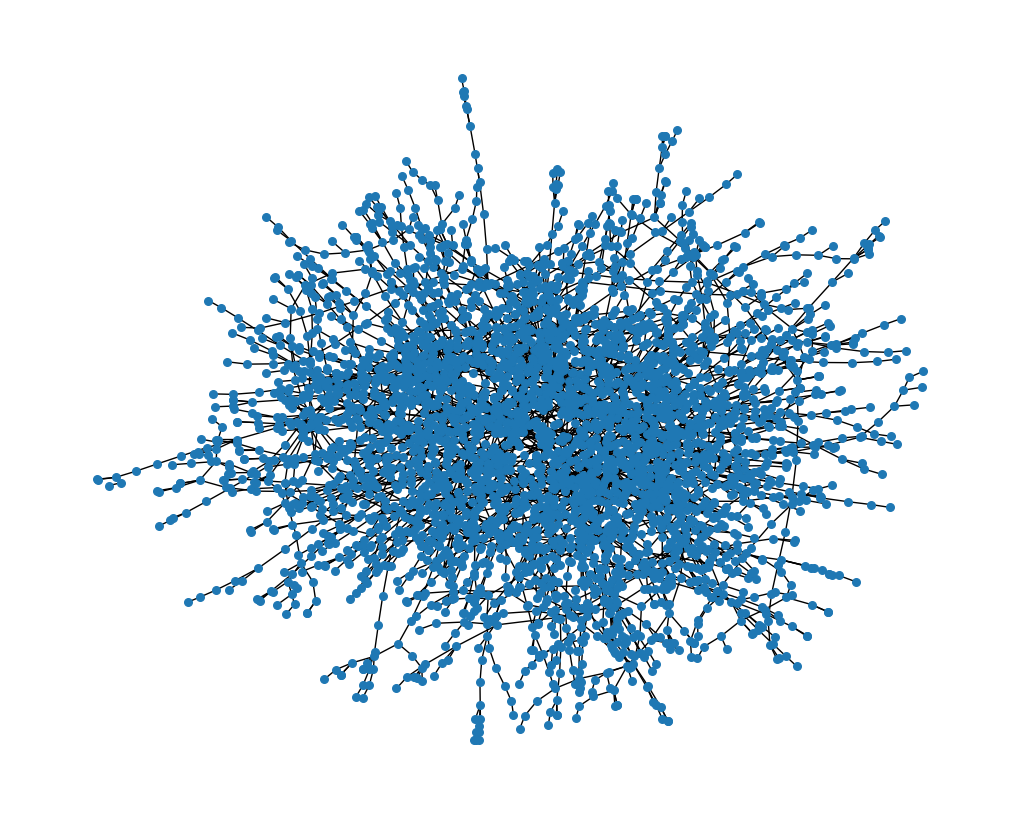

In [25]:
WS  = nx.watts_strogatz_graph(4030, k=2, p=0.99, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(WS, with_labels=False, node_size=30)
plt.show()

Justification of model: Watts-Strogatz (WS) graphs make it possible to generate graphs with the same amount of nodes and a similar average degree as the White Helmets dataset. These two attributes are very fundamental to a network, which is why we want to match them to see if we then find other similiarties between the White Helmets dataset and the WS network model. Watts-Strogatz graphs are known for its high clustering, which is somthing we expect to see in parts of the White Helmets dataset. Through the probability parameter (p) the randomness of the network can be controlled, which makes this kind of graph very suitable to compare against a real social network to see if there are any inorganic patterns to be discovered.

In [26]:
UserGraph_n_nodes = User_graph.number_of_nodes()
UserGraph_n_edges = User_graph.number_of_edges()

# Create a Barabasi network with roughly the same amount of edges.
# -> Here, 1 edge per added node is a close approximation.


print("\n--- Comparison: Real User–User Graph vs Watts–Strogatz Model ---\n")
print(f"Nodes: {UserGraph_n_nodes}")
print(f"Edges: {UserGraph_n_edges} (real) | {WS.number_of_edges()} (WS model)")

# --- Compare basic metrics ---
def graph_summary(G):
    G_u = G if not nx.is_directed(G) else G.to_undirected()
    n = G_u.number_of_nodes()
    degs = [d for _, d in G_u.degree()]
    avg_deg = sum(degs) / n if n > 0 else 0
    dens = nx.density(G_u)
    clust = nx.average_clustering(G_u)
    # Work on largest component for paths
    comps = list(nx.connected_components(G_u))
    largest = G_u.subgraph(max(comps, key=len))
    avg_path = nx.average_shortest_path_length(largest)
    return avg_deg, dens, clust, avg_path

avg_deg_real, dens_real, clust_real, path_real = graph_summary(User_graph)
avg_deg_WS, dens_WS, clust_WS, path_WS = graph_summary(WS)

print(f"Average degree: {avg_deg_real:.3f} (real) | {avg_deg_WS:.3f} (WS)")
print(f"Density: {dens_real:.6f} (real) | {dens_WS:.6f} (WS)")
print(f"Average clustering coefficient: {clust_real:.6f} (real) | {clust_WS:.6f} (WS)")
print(f"Average path length (largest component): {path_real:.3f} (real) | {path_WS:.3f} (WS)")


--- Comparison: Real User–User Graph vs Watts–Strogatz Model ---

Nodes: 4030
Edges: 4078 (real) | 4030 (WS model)
Average degree: 2.024 (real) | 2.000 (WS)
Density: 0.000502 (real) | 0.000496 (WS)
Average clustering coefficient: 0.299793 (real) | 0.000000 (WS)
Average path length (largest component): 8.903 (real) | 74.755 (WS)


In [ ]:
# PARAMETERS
n = 4030
k = 2
ps = np.linspace(0, 1, 10)  
trials = 5

means = []
stds = []

# Fortschrittsbalken über alle p-Werte
for p in tqdm(ps, desc="Processing p values"):
    values = []
    for t in range(trials):
        # Fortschritt in den inneren Schleifen anzeigen
        print(f"Generating graph for p={p:.2f}, trial={t+1}/{trials}...")
        
        # Generate Watts–Strogatz graph
        G = nx.watts_strogatz_graph(n, k, p)
        
        # If the graph is not connected, use largest connected component
        if not nx.is_connected(G):
            largest_cc = max(nx.connected_components(G), key=len)
            H = G.subgraph(largest_cc).copy()
        else:
            H = G
        
        # Compute average shortest path length (this can be slow!)
        asp = nx.average_shortest_path_length(H)
        values.append(asp)
    
    means.append(statistics.mean(values))
    stds.append(statistics.pstdev(values))
    print(f"Finished p={p:.2f}: mean={means[-1]:.3f}, std={stds[-1]:.3f}")

# --- Plot ---
plt.figure(figsize=(8,5))
plt.errorbar(ps, means, yerr=stds, marker='o', linestyle='-')
plt.xlabel('Rewiring probability p')
plt.ylabel('Average shortest path length (largest component)')
plt.title(f'Average shortest path vs p (n={n}, k={k}, trials={trials})')
plt.grid(True)
plt.show()

print("All computations finished successfully.")

In [ ]:
# PARAMETERS
n = 1000
k = 2
ps = np.linspace(0, 1, 10)  # 10 Werte zwischen 0 und 1
trials = 50

means = []
stds = []

for p in tqdm(ps, desc="Processing p values for clustering"):
    values = []
    for t in range(trials):
        
        # Generate Watts–Strogatz graph
        G = nx.watts_strogatz_graph(n, k, p)
        
        # Compute average clustering coefficient
        acc = nx.average_clustering(G)
        values.append(acc)
    
    means.append(statistics.mean(values))
    stds.append(statistics.pstdev(values))
    print(f"Finished p={p:.2f}: mean={means[-1]:.3f}, std={stds[-1]:.3f}")

# --- Plot ---
plt.figure(figsize=(8,5))
plt.errorbar(ps, means, yerr=stds, marker='o', linestyle='-')
plt.xlabel('Rewiring probability p')
plt.ylabel('Average clustering coefficient')
plt.title(f'Average clustering vs p (n={n}, k={k}, trials={trials})')
plt.grid(True)
plt.show()

print("All computations finished successfully.")

In [ ]:
## Sub WS graoh for the Largest Connected Component

In [ ]:
WS_LCC  = nx.watts_strogatz_graph(78, k=2, p=0.9, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(WS_LCC, with_labels=False, node_size=30)
plt.show()

In [ ]:
UserGraph_n_nodes = User_graph.number_of_nodes()
UserGraph_n_edges = User_graph.number_of_edges()

# Create a Barabasi network with roughly the same amount of edges.
# -> Here, 1 edge per added node is a close approximation.


print("\n--- Comparison: Real User–User Graph vs Watts–Strogatz Model with amounts of nodes as the LCC from User-User Graph ---\n")
print(f"Nodes: {UserGraph_n_nodes}")
print(f"Edges: {UserGraph_n_edges} (real) | {WS_LCC.number_of_edges()} (WS model)")

# --- Compare basic metrics ---
def graph_summary(G):
    G_u = G if not nx.is_directed(G) else G.to_undirected()
    n = G_u.number_of_nodes()
    degs = [d for _, d in G_u.degree()]
    avg_deg = sum(degs) / n if n > 0 else 0
    dens = nx.density(G_u)
    clust = nx.average_clustering(G_u)
    # Work on largest component for paths
    comps = list(nx.connected_components(G_u))
    largest = G_u.subgraph(max(comps, key=len))
    avg_path = nx.average_shortest_path_length(largest)
    return avg_deg, dens, clust, avg_path

avg_deg_real, dens_real, clust_real, path_real = graph_summary(User_graph)
avg_deg_WS_LCC, dens_WS_LCC, clust_WS_LCC, path_WS_LCC = graph_summary(WS_LCC)

print(f"Average degree: {avg_deg_real:.3f} (real) | {avg_deg_WS_LCC:.3f} (WS)")
print(f"Density: {dens_real:.6f} (real) | {dens_WS_LCC:.6f} (WS)")
print(f"Average clustering coefficient: {clust_real:.6f} (real) | {clust_WS_LCC:.6f} (WS)")
print(f"Average path length (largest component): {path_real:.3f} (real) | {path_WS_LCC:.3f} (WS)")

In [ ]:
# Plot meaningful distributions:

# Number of top nodes to compare
top_n = 20

# --- Centrality Calculations ---
eig_real = nx.eigenvector_centrality(User_graph, max_iter=2000)
eig_ws   = nx.eigenvector_centrality(WS, max_iter=2000)

close_real = nx.closeness_centrality(User_graph)
close_ws   = nx.closeness_centrality(WS)

deg_centrality_real = nx.degree_centrality(User_graph)
deg_centrality_ws   = nx.degree_centrality(WS)

betweenness_real = nx.betweenness_centrality(User_graph)
betweenness_ws   = nx.betweenness_centrality(WS)

# --- Compare top-n nodes for eigenvector centrality ---
def top_n_avg(centrality_dict, n=top_n):
    values_sorted = sorted(centrality_dict.values(), reverse=True)
    return np.mean(values_sorted[:n])

print(f"Average Eigenvector Centrality of top {top_n} nodes:")
print(f"Real: {top_n_avg(eig_real):.4f}, WS: {top_n_avg(eig_ws):.4f}")

# --- Average Closeness Centrality ---
print("Average Closeness Centrality:")
print(f"Real: {np.mean(list(close_real.values())):.4f}, WS: {np.mean(list(close_ws.values())):.4f}")

# --- Average Degree Centrality ---
print("Average Degree Centrality:")
print(f"Real: {np.mean(list(deg_centrality_real.values())):.4f}, WS: {np.mean(list(deg_centrality_ws.values())):.4f}")

# --- Average Betweenness Centrality ---
print("Average Betweenness Centrality:")
print(f"Real: {np.mean(list(betweenness_real.values())):.4f}, WS: {np.mean(list(betweenness_ws.values())):.4f}")

# --- Degree Distributions ---
deg_real = [d for _, d in User_graph.degree()]
deg_ws   = [d for _, d in WS.degree()]

plt.figure(figsize=(8,5))
plt.hist(deg_real, bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(deg_ws, bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution: Watts–Strogatz Model')
plt.show()

# --- Degree Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_ws.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality Distribution: Watts–Strogatz Model')
plt.show()

# --- Betweenness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(betweenness_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(betweenness_ws.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality Distribution: Barabási–Albert Model')
plt.show()

# --- Closeness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(close_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(close_ws.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality Distribution: Watts–Strogatz Model')
plt.show()

# --- Eigenvector Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(eig_real.values()), bins=50, alpha=0.7, color='skyblue', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality Distribution: Real User Graph')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(list(eig_ws.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality Distribution: Barabási–Albert Model')
plt.show()

### Step 6: Construct Barabási-Albert Graph

In [62]:
UserGraph_n_nodes = User_graph.number_of_nodes()
UserGraph_n_edges = User_graph.number_of_edges()

# Create a Barabasi network with roughly the same amount of edges.
# -> Here, 1 edge per added node is a close approximation.
m_target = max(1, int(round(UserGraph_n_edges / UserGraph_n_nodes)))

BA = nx.barabasi_albert_graph(UserGraph_n_nodes, m_target, seed=42)

plt.figure(figsize=(10, 8))
nx.draw(BA, with_labels=False, node_size=30)
plt.show()


--- Comparison: Real User–User Graph vs Barabási–Albert Model ---

Nodes: 4030
Edges: 4078 (real) | 4029 (BA model)
Average degree: 2.024 (real) | 2.000 (BA)
Density: 0.000502 (real) | 0.000496 (BA)
Average clustering coefficient: 0.299793 (real) | 0.000000 (BA)
Average path length (largest component): 8.903 (real) | 7.834 (BA)


In [ ]:
Justification of model: The Barabási–Albert model especially focusses on the scale-free structure which can be often found on real social networks. In these networks, a small hub of nodes usually accumulate a disproportionally large number of edges, while the rest only holds few. This makes the model well-suited to compare it to the White Helmets network, since it allows detecting unnatural clustering behavior that potentially indicates coordinated behavior.

In [ ]:
print("\n--- Comparison: Real User–User Graph vs Barabási–Albert Model ---\n")
print(f"Nodes: {UserGraph_n_nodes}")
print(f"Edges: {UserGraph_n_edges} (real) | {BA.number_of_edges()} (BA model)")

# --- Compare basic metrics ---
def graph_summary(G):
    G_u = G if not nx.is_directed(G) else G.to_undirected()
    n = G_u.number_of_nodes()
    degs = [d for _, d in G_u.degree()]
    avg_deg = sum(degs) / n if n > 0 else 0
    dens = nx.density(G_u)
    clust = nx.average_clustering(G_u)
    # Work on largest component for paths
    comps = list(nx.connected_components(G_u))
    largest = G_u.subgraph(max(comps, key=len))
    avg_path = nx.average_shortest_path_length(largest)
    return avg_deg, dens, clust, avg_path

avg_deg_real, dens_real, clust_real, path_real = graph_summary(User_graph)
avg_deg_ba, dens_ba, clust_ba, path_ba = graph_summary(BA)

print(f"Average degree: {avg_deg_real:.3f} (real) | {avg_deg_ba:.3f} (BA)")
print(f"Density: {dens_real:.6f} (real) | {dens_ba:.6f} (BA)")
print(f"Average clustering coefficient: {clust_real:.6f} (real) | {clust_ba:.6f} (BA)")
print(f"Average path length (largest component): {path_real:.3f} (real) | {path_ba:.3f} (BA)")

In [ ]:
Parametrization: The primary parameters that can be controlled are the number of nodes and the number of edges added per new node. The Barabási–Albert model always creates a fully connected network. Therefore, the number of edges within the model can only be set to an approximate amount of the edge count of the real network. Setting m to 1 already results in an edge count that is very close to the real White Helmets network, making it a reasonable and representative choice for comparison.

In [ ]:
# --- Barabási–Albert (BA) Model Analysis ---

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Number of top nodes to compare
top_n = 20

# --- Centrality Calculations ---
eig_ba = nx.eigenvector_centrality(BA, max_iter=2000)
close_ba = nx.closeness_centrality(BA)
deg_centrality_ba = nx.degree_centrality(BA)
betweenness_ba = nx.betweenness_centrality(BA)

# --- Compare top-n nodes for eigenvector centrality ---
def top_n_avg(centrality_dict, n=top_n):
    values_sorted = sorted(centrality_dict.values(), reverse=True)
    return np.mean(values_sorted[:n])

print(f"Average Eigenvector Centrality of top {top_n} nodes (BA): {top_n_avg(eig_ba):.4f}")
print(f"Average Closeness Centrality (BA): {np.mean(list(close_ba.values())):.4f}")
print(f"Average Degree Centrality (BA): {np.mean(list(deg_centrality_ba.values())):.4f}")
print(f"Average Betweenness Centrality (BA): {np.mean(list(betweenness_ba.values())):.4f}")

# --- Degree Distribution ---
deg_ba = [d for _, d in BA.degree()]

plt.figure(figsize=(8,5))
plt.hist(deg_ba, bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution: Barabási–Albert Model')
plt.show()

# --- Degree Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality Distribution: Barabási–Albert Model')
plt.show()

# --- Betweenness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(betweenness_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality Distribution: Barabási–Albert Model')
plt.show()

# --- Closeness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(close_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality Distribution: Barabási–Albert Model')
plt.show()

# --- Eigenvector Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(eig_ba.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality Distribution: Barabási–Albert Model')
plt.show()

In [ ]:
## Step 7: Construct Erdos-Renyi Graph

In [ ]:
# Construct the Erdős–Rényi graph to compare it to

n_nodes = User_graph.number_of_nodes()
n_edges = User_graph.number_of_edges()

# --- Create ER graph ---
# p = probability of edge creation in G(n, p)
p = n_edges / (n_nodes * (n_nodes - 1) / 2)
ER = nx.erdos_renyi_graph(n_nodes, p, seed=42)

plt.figure(figsize=(10, 8))
nx.draw(ER, with_labels=False, node_size=30)
plt.show()

In [ ]:
Justification of the model: The Erdős–Rényi model also provides a valuable baseline for comparison with the White Helmets dataset because it represents the simplest form of a random network. By design, the Erdős–Rényi model does not show any preferential attachment, clustering tendency, or coordinated behavior. By comparing it to the White Helmets Network, we can observe how much of the observed structure in the real data could emerge purely by chance.

In [ ]:
# --- Function to compute summary metrics ---
def graph_summary(G):
    G_u = G if not nx.is_directed(G) else G.to_undirected()
    n = G_u.number_of_nodes()
    degs = [d for _, d in G_u.degree()]
    avg_deg = sum(degs) / n if n > 0 else 0
    dens = nx.density(G_u)
    clust = nx.average_clustering(G_u)
    comps = list(nx.connected_components(G_u))
    largest = G_u.subgraph(max(comps, key=len))
    avg_path = nx.average_shortest_path_length(largest)
    return avg_deg, dens, clust, avg_path

# --- Compare metrics ---
avg_deg_real, dens_real, clust_real, path_real = graph_summary(User_graph)
avg_deg_er, dens_er, clust_er, path_er = graph_summary(ER)

print("\n--- Comparison: Real User-User Graph vs Erdős–Rényi Model ---\n")
print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges} (real) | {ER.number_of_edges()} (ER model)")
print(f"Average degree: {avg_deg_real:.3f} (real) | {avg_deg_er:.3f} (ER)")
print(f"Density: {dens_real:.6f} (real) | {dens_er:.6f} (ER)")
print(f"Average clustering coefficient: {clust_real:.6f} (real) | {clust_er:.6f} (ER)")
print(f"Average path length (largest component): {path_real:.3f} (real) | {path_er:.3f} (ER)")

In [ ]:
Parametrization: There is very little inherent parametrization in a standard ER model. While the node count is being set to the exact amount of the real network, the edge count is calculated as the overall probability of an existing edge within the White Helmets Network: p = n_edges / (n_nodes * (n_nodes - 1) / 2)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# --- Centrality Calculations for ER Model ---
top_n = 20

eig_er = nx.eigenvector_centrality(ER, max_iter=10000)
close_er = nx.closeness_centrality(ER)
deg_centrality_er = nx.degree_centrality(ER)
betweenness_er = nx.betweenness_centrality(ER)

# --- Compare top-n Eigenvector Centrality ---
def top_n_avg(centrality_dict, n=top_n):
    values_sorted = sorted(centrality_dict.values(), reverse=True)
    return np.mean(values_sorted[:n])

print(f"Average Eigenvector Centrality of top {top_n} nodes (ER): {top_n_avg(eig_er):.4f}")
print(f"Average Closeness Centrality (ER): {np.mean(list(close_er.values())):.4f}")
print(f"Average Degree Centrality (ER): {np.mean(list(deg_centrality_er.values())):.4f}")
print(f"Average Betweenness Centrality (ER): {np.mean(list(betweenness_er.values())):.4f}")

# --- Degree Distribution ---
deg_er = [d for _, d in ER.degree()]

plt.figure(figsize=(8,5))
plt.hist(deg_er, bins=50, alpha=0.7, color='salmon')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution: Erdős–Rényi (ER) Model')
plt.show()

# --- Degree Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(deg_centrality_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Density')
plt.title('Degree Centrality Distribution: Erdős–Rényi (ER) Model')
plt.show()

# --- Betweenness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(betweenness_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Density')
plt.title('Betweenness Centrality Distribution: Erdős–Rényi (ER) Model')
plt.show()

# --- Closeness Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(close_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Density')
plt.title('Closeness Centrality Distribution: Erdős–Rényi (ER) Model')
plt.show()

# --- Eigenvector Centrality Distribution ---
plt.figure(figsize=(8,5))
plt.hist(list(eig_er.values()), bins=50, alpha=0.7, color='salmon', density=True)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Density')
plt.title('Eigenvector Centrality Distribution: Erdős–Rényi (ER) Model')
plt.show()

### Step 8: Evaluation of the results

In [ ]:
'''
Patterns found in the network
--> see L1 (agenda broadcasting etc) & Daniel's findings
'''

### 1. Density

### 2. Node degree

### 3. Average Clustering Coefficient

In [ ]:
Our hypothesis is that people are more likely to repost videos from someone they know. Therefore, within the White Helmets organization where we assume they know one another all nodes should stick quite together. There may be tiny clusters within the organization as happens in large networks where subgroups of e.g. friends form. Given that we see a CC of +- 0.3 for the User-User Graph we think this to be the case. For the User-Video bipartite grapg the CC is 0 as expected.



### 4. Betweenness Centrality

### 5. Degree Centrality

### 6. Average Shortest Path Length

## Discussion

In [ ]:
#DISCUSS FINDINGS OF (IN)ORGANIC PATTERNS
'''
likely mix of all network families in terms of characteristics
what organic patterns do we see
what inorganic patterns do we see
future research
'''